# Extracting Motor Evoked Potentials

In [3]:
# importing relevant libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
from open_ephys.analysis import Session
from scipy.signal import find_peaks
import json
import pickle

# setting notebook theme
sns.set_palette("Spectral")
palette = sns.color_palette()
plt.style.use(['science', 'grid'])


## Defining relevant folders and file paths

In [9]:
# relevant input paths
master_folder = '/Volumes/STORAGE 1.0/UNIC Research/Motor Evoked Potentials/MEPSSEP_raw_data/post 93'
path_to_spreadsheet = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MICE_LIST_EEG.xlsx'
path_to_recording = 'Record Node 103/experiment1/recording1/continuous/OE_FPGA_Acquisition_Board-100.Rhythm Data'

## Extracting data from spreadsheet

In [49]:
spreadsheet = pd.read_excel(path_to_spreadsheet, sheet_name='MEP2024')

# sorting data by date
spreadsheet['session'] = pd.to_datetime(spreadsheet['session'], format='%Y-%m-%d_%H-%M-%S')
spreadsheet = spreadsheet.sort_values(by = 'session')

# selecting relevant sessions
cut_off_date = pd.to_datetime('2024-03-02_00-00-00', format = '%Y-%m-%d_%H-%M-%S')
march_session_data = spreadsheet[spreadsheet['session'] > cut_off_date]

# filtering sessions by sessionType and sessionClass
def sort_by_type(data, session_type, session_class):
    return data[(march_session_data['sessionType'].str.contains(session_type)) & (march_session_data['sessionClass'].str.contains(session_class))].reset_index()
    
mep_sciatic = sort_by_type(march_session_data, 'sciatic', 'MEP')
mep_skull = sort_by_type(march_session_data, 'skull', 'MEP')
mep_spine = sort_by_type(march_session_data, 'spine', 'MEP')

# adding session dates as a readable string and converting subrec to int
mep_sciatic['session_dates'] = mep_sciatic['session'].dt.strftime('%Y-%m-%d_%H-%M-%S')
mep_sciatic['subrec'] = mep_sciatic['subrec'].astype(int)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MICE_LIST_EEG.xlsx'

## Importing data for a single session

In [13]:
# obtaining the relevant folder name from the 'session_date' column
session_date = '2024-03-07_18-03-10'
path_to_raw_data = os.path.join(master_folder, session_date)
path_to_sample_numbers = os.path.join(master_folder, session_date, path_to_recording, 'sample_numbers.npy')

# creating folders for figures and data objects obtained from extraction
path_for_extracted = os.path.join(master_folder, session_date, 'extracted')
if not os.path.exists(path_for_extracted):
    os.makedirs(path_for_extracted)

# analysing session length by extracting total number of samples
sample_numbers = np.load(path_to_sample_numbers)
data_length = sample_numbers.max() - sample_numbers.min()

# loading and checking session data

session = Session(path_to_raw_data)
recording = session.recordnodes[0].recordings[0]
raw_data = recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=data_length)

raw_data.shape

(2255420, 16)

## Visually identifying the event channel

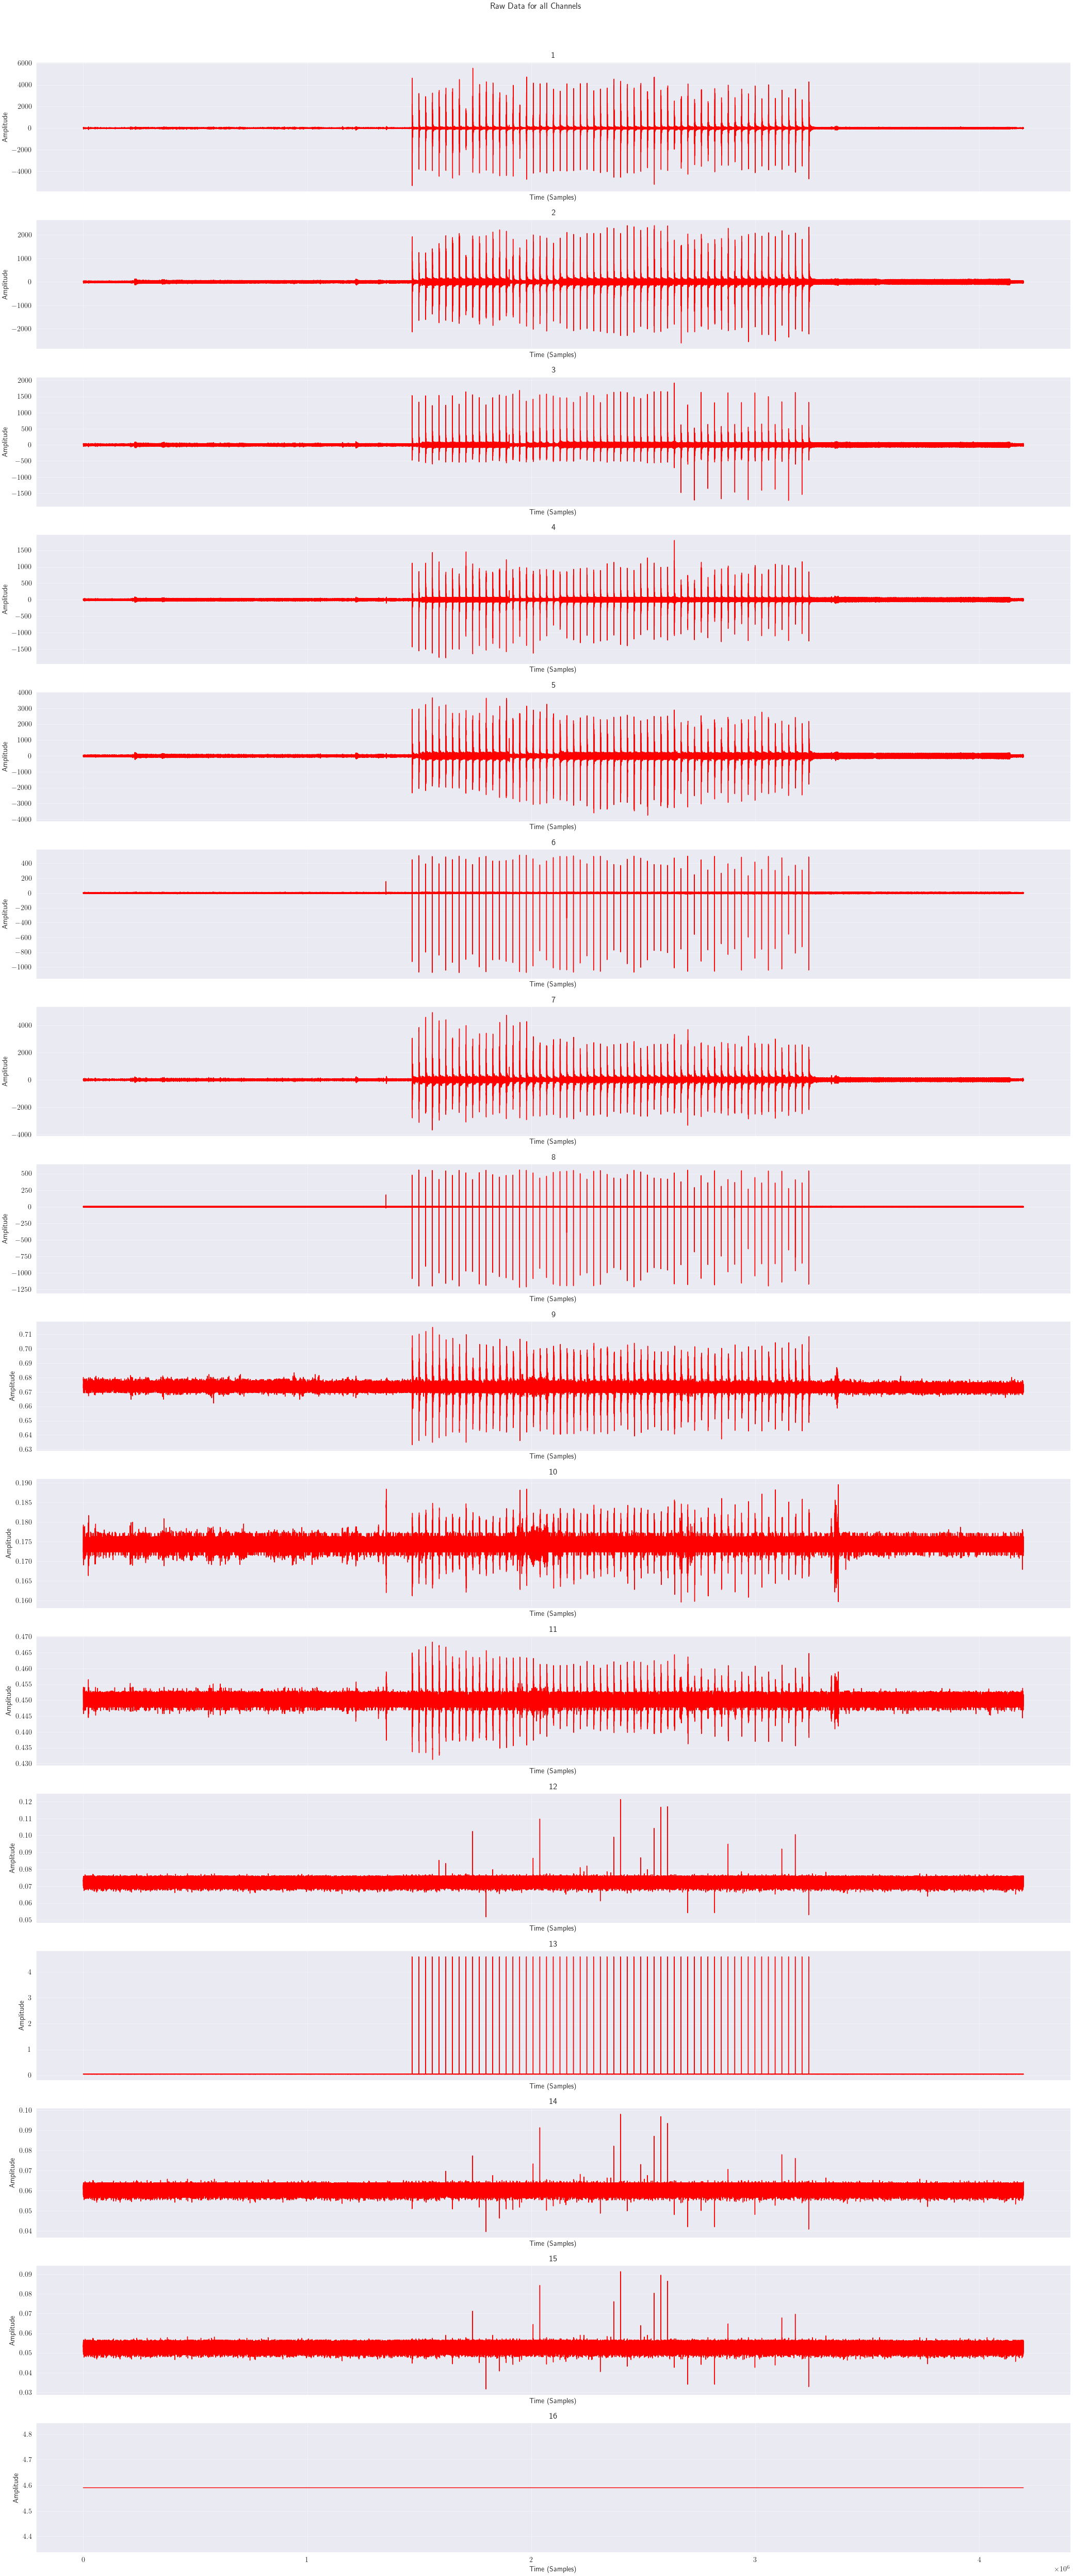

In [20]:
channel_names = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16}

fig1, axs1 = plt.subplots(16, 1, figsize=(21, 16*3 + 3), sharex = True)

count = 0
all_channels = {}

for i in range(0,16):
    
    # storing each sample as an individual array
    channel_data = (recording.continuous[0].get_samples(start_sample_index=0, end_sample_index=data_length, selected_channels=[i])).flatten()
    
    all_channels[channel_names[i]] = channel_data
    
    # plotting all the data
    time_axis = [t for t in range(len(channel_data))]
    axs1[i].plot(time_axis, channel_data, color = 'red')
    axs1[i].set_title(channel_names[i])
    axs1[i].set_xlabel('Time (Samples)')
    axs1[i].set_ylabel('Amplitude')
    
    count+=1

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.4)
fig1.suptitle('Raw Data for all Channels')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

fig1.savefig(os.path.join(path_for_extracted, 'raw_data.png'))

## Creating useful functions for extraction and exporting

### Save object function

In [7]:
# function to save python objects as either json or pkl files

def save_object(object, name, path, type):
    if type == 'pkl':
        file_name = name + ".pkl"
        full_path = os.path.join(path, file_name)
        with open(full_path, 'wb') as f:
            pickle.dump(object, f)
    elif type == 'json':  # Use elif instead of if to avoid checking both conditions if the first one is true
        file_name = name + ".json"
        full_path = os.path.join(path, file_name)
        with open(full_path, 'w') as f:
            json.dump(object, f)
    else:
        raise ValueError("Unsupported file type. Please use 'pkl' or 'json'.")

### Event timing extraction function

In [8]:
# event extraction function

def extract_events(data, event_channel_number):

    threshold = 0.5 # threshold for detecting events which are always above 0.5
    event_channel_data = data[:,event_channel_number - 1]

    events = {}  # initialize a dictionary to store events with unique identifiers
    event_number = 1  # start naming events from 1

    is_event = False # initialize a flag to track if an event is ongoing
    event_start = None
    event_end = None

    for index, value in enumerate(event_channel_data):
        if value >= threshold:
            if not is_event:
                event_start = index  # record the start of a new event
                is_event = True
        else:
            if is_event:
                event_end = index - 1  # record the end of the ongoing event
                events[event_number] = (event_start, event_end)  # store the event
                event_number += 1  # increment event name for the next event
                is_event = False # reset the event flag

    # check if an event is ongoing at the end of the channel
    if is_event:
        events[event_number] = (event_start, len(event_channel_data - 1))  # handle the final ongoing event

    return events

### Event data extraction function

In [9]:
# function to get event data using the extracted events

def get_event_data(events_dictionary):
    
    if not type(events_dictionary) == dict:
        raise ValueError("Input must be a dictionary of events")
    
    data = []

    for channel in range(0,16):
        extracted_data = []
        for event_number, (start, end) in events_dictionary.items():
            start_actual = int(start - pre_stimulus)
            end_actual = int(start + post_stimulus)
            event_data = raw_data[start_actual:end_actual,channel]
            extracted_data.append(event_data)

        data.append(np.vstack(extracted_data).T)

    return np.array(data)

### Samples to milliseconds conversion function 

In [10]:
# function to convert ms durations to sample numbers

def seconds_to_samples(frequency, duration):
    duration_in_seconds = duration*(10**(-3))
    samples = frequency * duration_in_seconds
    return samples

## Extracting events and generating EMP matrix

In [11]:
# extracting events from the event channel

event_channel = 13
extracted_events = extract_events(raw_data, event_channel)

save_object(extracted_events, 'extracted events', path_for_extracted, 'pkl')
save_object(extracted_events, 'extracted_events', path_for_extracted, 'json')

# defining experiment parameters

sampling_rate = 30000 # 30,000 Hz
pre_stimulus_ms = 10 # 100 ms
post_stimulus_ms = 100 # 200 ms

# conversion to samples
pre_stimulus = int(seconds_to_samples(sampling_rate, pre_stimulus_ms))
post_stimulus = int(seconds_to_samples(sampling_rate, post_stimulus_ms))

pre_stimulus,post_stimulus

(300, 3000)

In [12]:
# generates a list of event data in desired temporal region (event related activity)

processed_data = get_event_data(extracted_events)

averaged_data = np.mean(processed_data, axis = 2).T

# save_object(processed_data, 'processed_data', path_for_extracted, 'pkl')
# save_object(processed_data, 'processed_data', path_for_extracted, 'json')

processed_data.shape

(16, 3300, 60)

## Visualisation / Verification

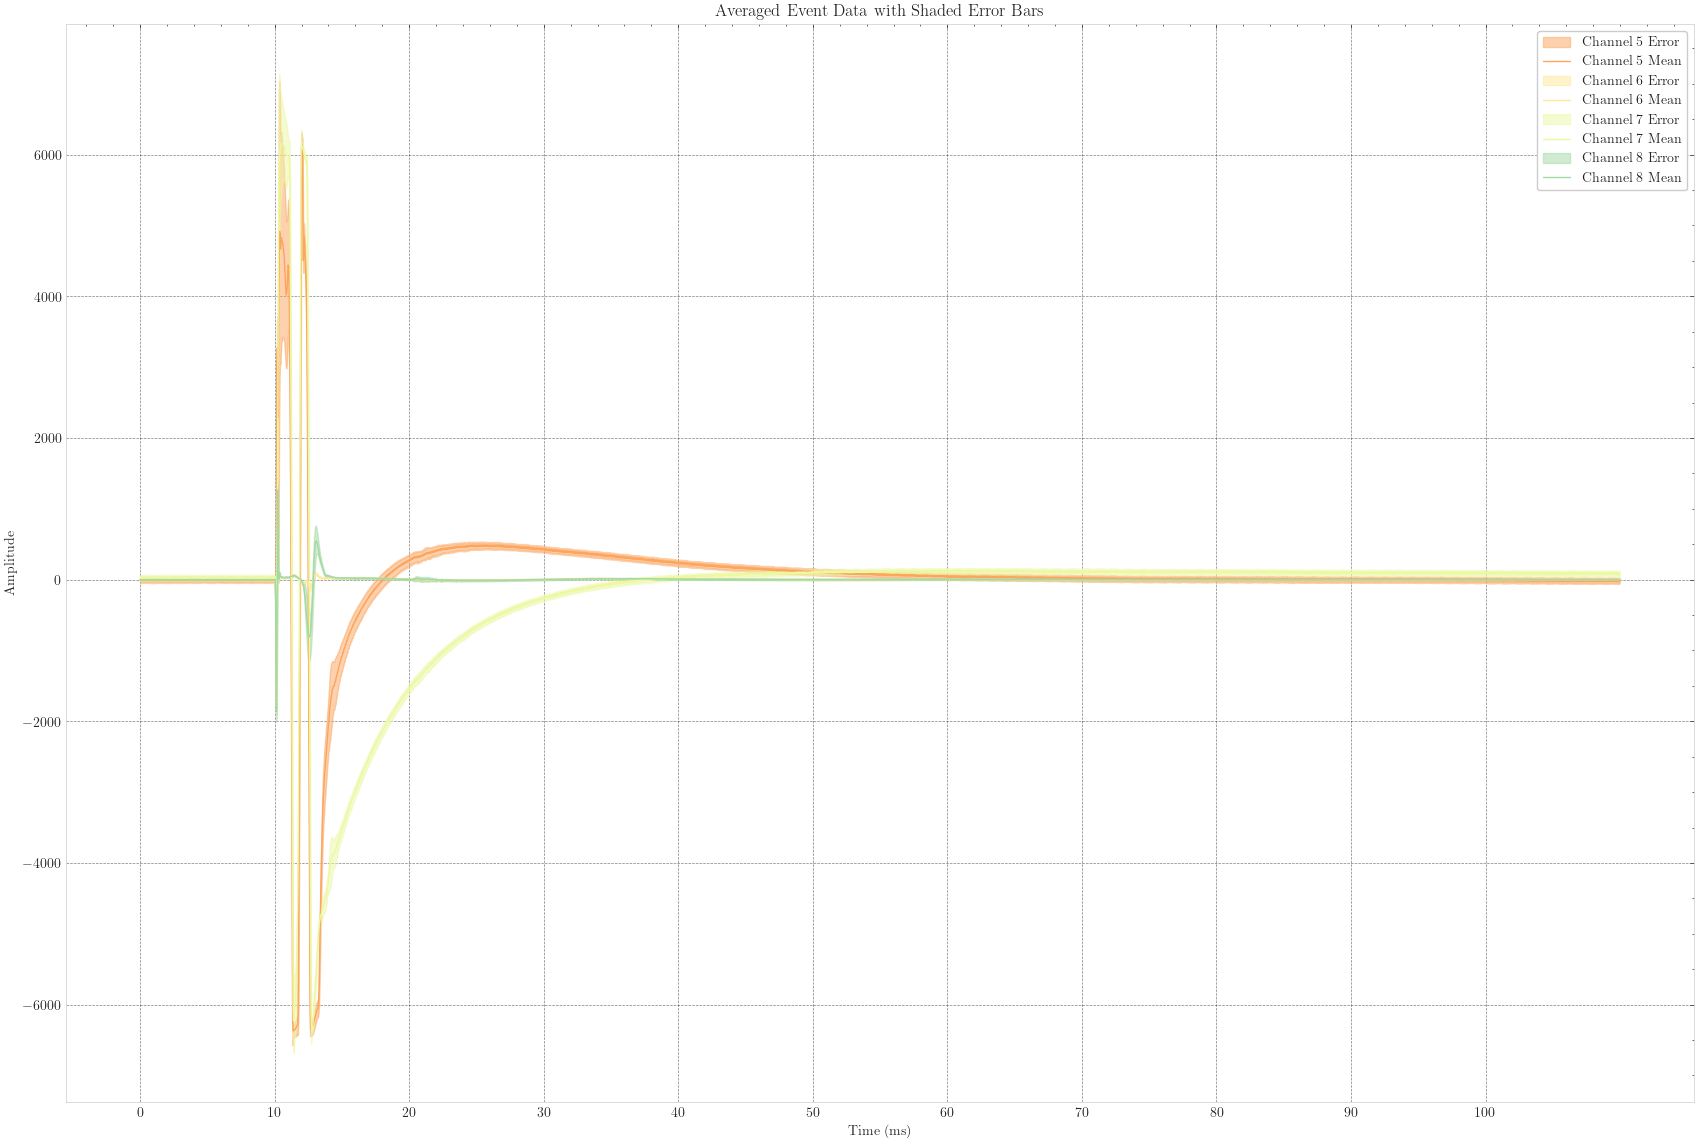

In [13]:
mean_data = np.mean(processed_data[4:8, :, :], axis=2)
std_data = np.std(processed_data[4:8, :, :], axis=2)

fig2, axs2 = plt.subplots(1, 1, figsize=(21, 14))

time_axis_ms = np.arange(processed_data.shape[1]) * (1000 / 30000)
tick_positions_samples = np.arange(0, np.max(time_axis_ms), 10)

# Plot for specific channels
for channel_index in range(0,4):

    color = palette[channel_index + 7 % len(palette)]
    
    # Calculate upper and lower bounds
    upper_bound = mean_data[channel_index] + std_data[channel_index]
    lower_bound = mean_data[channel_index] - std_data[channel_index]

    # Plot shaded error bars
    axs2.fill_between(time_axis_ms, lower_bound, upper_bound, alpha=0.5, label=f'Channel {channel_index + 5} Error', color = color)

    # Plot mean on top for clarity
    axs2.plot(time_axis_ms, mean_data[channel_index], label=f'Channel {channel_index + 5} Mean', color = color)

axs2.set_xlabel('Time (ms)')
axs2.set_ylabel('Amplitude')
axs2.set_xticks(tick_positions_samples)
axs2.set_title('Averaged Event Data with Shaded Error Bars')
axs2.legend()

fig2.savefig(os.path.join(path_for_extracted, 'averaged_data.png'))

## Identifying MEPs peaks


dict_keys(['peak_heights', 'left_thresholds', 'right_thresholds', 'prominences', 'left_bases', 'right_bases', 'widths', 'width_heights', 'left_ips', 'right_ips'])
dict_keys(['peak_heights', 'left_thresholds', 'right_thresholds', 'prominences', 'left_bases', 'right_bases', 'widths', 'width_heights', 'left_ips', 'right_ips'])
dict_keys(['peak_heights', 'left_thresholds', 'right_thresholds', 'prominences', 'left_bases', 'right_bases', 'widths', 'width_heights', 'left_ips', 'right_ips'])
dict_keys(['peak_heights', 'left_thresholds', 'right_thresholds', 'prominences', 'left_bases', 'right_bases', 'widths', 'width_heights', 'left_ips', 'right_ips'])
[]


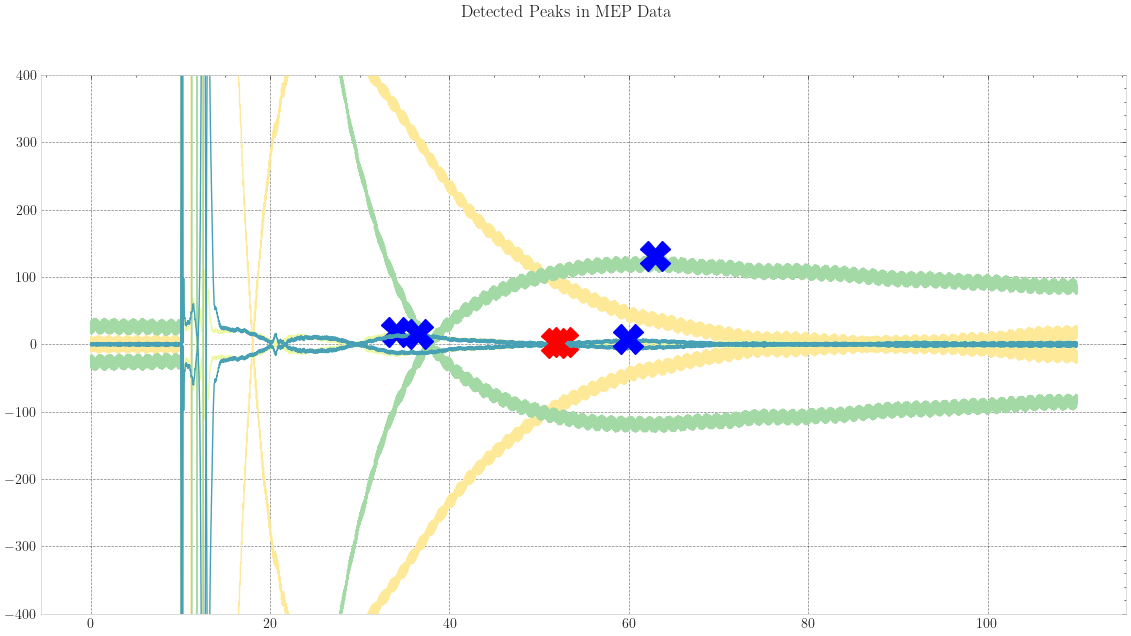

In [15]:
all_positive_peaks = []
all_positive_properties = []
all_negative_peaks = []
all_negative_properties = []

fig3, axs3 = plt.subplots(1, 1,figsize=(14, 7), sharex = True)
fig3.suptitle('Detected Peaks in MEP Data')

for i in range(0,4):   
    
    positive_data = mean_data[i]
    negative_data = -mean_data[i] 
    
    # find peaks with specified parameters
    positive_peaks, positive_properties = find_peaks(positive_data, threshold=0.2, height= 0.5, distance = 500, prominence = 0.3, width=5)
    negative_peaks, negative_properties = find_peaks(negative_data, threshold=0.2, height = 0.5, distance = 500, prominence = 0.3, width = 5)
    
    print(positive_properties.keys())

    # plot properties
    
    # plt.title('Detected Peaks in MEP Data')
    # plt.xlabel('Time (ms)')
    # plt.xticks(tick_positions_samples)
    # plt.ylabel('Amplitude')
    
    # plot data and detected peaks
    
    # axs3[0].set_title('Positive peaks')
    # axs3[1].set_title('Negative peaks')
    # axs3[0].set_ylim(-400,400)
    axs3.set_ylim(-400,400)
    axs3.plot(time_axis_ms, positive_data, label=f'Channel {i + 5} Normal', alpha = 1, color = palette[(i + 2)% len(palette)])
    axs3.plot(time_axis_ms, negative_data, label=f'Channel {i + 5} Inverted', alpha = 1, color = palette[(i + 2)% len(palette)])
    axs3.plot(positive_peaks * (1000/30000), positive_data[positive_peaks], "X", ms = 21, color = 'blue')
    axs3.plot(negative_peaks * (1000/30000), negative_data[negative_peaks], "X", ms = 21, color = 'red')
    
    # store/print peaks that only occur from after stimulus (t > 110ms= 3150 samples of final data)
    for peak in range(len(positive_peaks)):
        if positive_peaks[peak] > 3270:
            all_positive_peaks.append([positive_peaks[peak], positive_properties['peak_heights'][peak]])
    for peak in range(len(negative_peaks)):
        if negative_peaks[peak] > 3270:
            all_negative_peaks.append([negative_peaks[peak], negative_properties['peak_heights'][peak]])
    
    # print(f"For channel {i} Peaks at indices:", positive_peaks)
    # print(f"For channel {i} Peak heights:", positive_properties['peak_heights'])
    # print(f"For channel {i} Peaks at indices:", negative_peaks)
    # print(f"For channel {i} Peak heights:", negative_properties['peak_heights'])

# axs3.legend()
# axs3[1].legend()
# plt.subplots_adjust(top=0.9)
# plt.show()

fig3.savefig(os.path.join(path_for_extracted, 'detected_peaks.png'))

print(all_positive_properties)

## Transforming peak data for further analysis

In [55]:
all_peaks = all_negative_peaks + all_positive_peaks
all_peaks = sorted(all_peaks, key=lambda x: x[0])
all_peaks = [[entry[0] * (1/30), entry[1]] for entry in all_peaks]

save_object(all_peaks, 'all_peaks', path_for_extracted, 'pkl')
save_object(all_peaks, 'all_peaks', path_for_extracted, 'json')